In [1]:
import pandas as pd
import numpy as np
import math
import os
import datetime
import matplotlib.pyplot as plt
import math

In [2]:
# Paths for input and output
path_in = "./../data/"
path_out = "./../data/"

In [3]:
# Create dictionary for mapping of VehId to Vehicle_Type
df_IceHev = pd.read_excel (path_in+'/VED_Static_Data_ICE&HEV.xlsx')
df_IceHev.rename(columns={'Vehicle Type': 'Vehicle_Type'}, inplace=True)
df_PhevEv = pd.read_excel (path_in+'/VED_Static_Data_PHEV&EV.xlsx')
df_PhevEv.rename(columns={'EngineType': 'Vehicle_Type'}, inplace=True)
df_VehId = df_IceHev.append(df_PhevEv, ignore_index = True)
df_VehId.sort_values(by='VehId', inplace=True)
df_VehId = df_VehId.set_index('VehId')
pd.set_option("display.max_rows", None, "display.max_columns", None)
dictVehId = df_VehId.to_dict('index')
#dictVehId[12]['Vehicle_Type']

# Energy Consumption Calculation

In [4]:
def calculateEnergyConsumption(df):
    df_org = df.copy()
    column_name = 'Energy_Consumption'
    if column_name not in df.columns:
        #print("Create column", column_name)
        df[column_name] = ""

    arr_VehId = df[["VehId" , "Vehicle Speed[km/h]", "MAF[g/sec]", "Short Term Fuel Trim Bank 1[%]", "Long Term Fuel Trim Bank 1[%]", "HV Battery Current[A]", "HV Battery Voltage[V]", column_name]].to_numpy()
    list_Energy_Consumption = []
    for row in arr_VehId:
        vehicle_type = dictVehId[row[0]]['Vehicle_Type']
        if vehicle_type == "ICE" or vehicle_type == "HEV":
            '''
            The formula to calculate the energy consumption is as following:

            Energy consumption=DrivingLength/100*MassAirFlow*(1+ShortTermFuelTrimBank1/100+LongTermFuelTrimBank1/100)/AirFuelRation

            where the Mass Air Flow is measured by gallon per second, Driving Length is measured by km, and the Air Fuel 
            Ration is provided with the value of 14.08 according to a literature:

            G. Oh, D. J. Leblanc and H. Peng, "Vehicle Energy Dataset (VED), A Large-Scale Dataset for Vehicle Energy 
            Consumption Research," in IEEE Transactions on Intelligent Transportation Systems, 
            doi: 10.1109/TITS.2020.3035596.
            '''
            #print("ICE or HEV found")
            # calculate energy consumption
                # /3600 as sampling rate is 1 sec ; value from "Vehicle Speed[km/h]"
                # The reason is as following:
                # row[1] is measured by km/h, which is treated to be the constant value during the sampling time of one second.
                # So, if we need to calculate the length during each sampling time, we need to multiple the speed (measured by km/h) by the duration (measured by h), which lead to:
                # row[1]*1/60/60=row[1]/3600
            DrivingLength = row[1] / 3600        # row[1] = Vehicle Speed[km/h]
            MassAirFlow =   row[2] * 3.78541     # recalculation from gallons to liters; value from "MAF[g/sec]"
            ShortTermFuelTrimBank1 = row[3]      # value from "Short Term Fuel Trim Bank 1[%]"
            LongTermFuelTrimBank1 = row[4]       # value from "Long Term Fuel Trim Bank 1[%]"
            AirFuelRation = 14.08
            #print("Length=", DrivingLength, "MassAirFlow=", MassAirFlow, "ShortTermFuelTrimBank1=", ShortTermFuelTrimBank1, "LongTermFuelTrimBank1=", LongTermFuelTrimBank1)
            in_liter_per_hour=DrivingLength/100*MassAirFlow*(1+ShortTermFuelTrimBank1/100+LongTermFuelTrimBank1/100)/AirFuelRation
            # recalcualte energy consuption into kWh ; 1 kw*h = 0.1123 liter
            in_kilo_watts_perHour = in_liter_per_hour / 0.1123
            #if not math.isnan(in_kilo_watts_perHour):
            #  print("EC =", in_kilo_watts_perHour, "kWh (", in_liter_per_hour, ")" )
            list_Energy_Consumption.append(in_kilo_watts_perHour)

        elif vehicle_type == "PHEV" or vehicle_type == "EV":
            '''
            The energy consumption for EV can be calculated by integrating the voltage and current of the EV battery over 
            time, and this energy consumption can be measured by kw*h.

            The convert between EV energy consumption (kw*h) and gas consumption (measured by liter) can be achieved as 
            following:

            1 kw*h = 0.1123 liter

            The EV energy consumption calculation can be referred from: 
            https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiY3Jzc3K70AhVpo4sKHTLUA9gQFnoECAYQAQ&url=https%3A%2F%2Fwww.mdpi.com%2F1996-1073%2F8%2F8%2F8573%2Fpdf&usg=AOvVaw3LyboWSueHI9UM0mJe5ypq

            The convert from kw*h to liter can be referred from: 
            https://en.wikipedia.org/wiki/Miles_per_gallon_gasoline_equivalent#Description
            '''
            #print("PHEV or EV found")
            # calculate energy consumption
            in_watts = row[5] * row[6] * (-1) # = "HV Battery Current[A]" * "HV Battery Voltage[V]", *(-1) EV formula needs to interpreted in that way that the consumed energy is negative while the produced one is positive
            in_kilo_watts = in_watts / 1000
            # recalcualte energy consuption into kWh
            # measurement of A in 1 sec ; V in 5 sec => Therefore one line covers the smaller unit 1 second
            #print("HV Battery Current[A]", row[5], "HV Battery Voltage[V]", row[6])
            in_kilo_watts_perHour = in_kilo_watts / 3600
            #print("EC =", in_kilo_watts_perHour, "kWh (", in_kilo_watts, in_watts, ")" )
            list_Energy_Consumption.append(in_kilo_watts_perHour)

        else:
            print("Unknown Vehicle_Type", row[0], "found")

    #df['Energy_Consumption'] = list_Energy_Consumption
    df_org['Energy_Consumption'] = list_Energy_Consumption
    return df_org

# Reworking of all original files

In [5]:
list_files = []    
for file in os.listdir(path_in):
    if file.endswith("_week.csv"):
        list_files.append(file)

In [6]:
time_overall_start = datetime.datetime.now().timestamp()
for file in list_files:
    time_start = datetime.datetime.now().timestamp()
    df = pd.read_csv (path_in + file)
    #print(df.info())
    df = calculateEnergyConsumption(df)
    #print(df.Energy_Consumption.describe())
    #print(df.info())
    df.to_csv(path_out + file, index=False, na_rep='nan')
    time_end = datetime.datetime.now().timestamp()
    print("Execution time = ", file, ":", (time_end-time_start))
    
    #break
    
time_overall_end = datetime.datetime.now().timestamp()
print("Execution time overall = ", (time_overall_end-time_overall_start))

Execution time =  VED_171101_week.csv : 9.888816118240356
Execution time =  VED_171108_week.csv : 9.541045904159546
Execution time =  VED_171115_week.csv : 10.846029043197632
Execution time =  VED_171122_week.csv : 8.577940940856934
Execution time =  VED_171129_week.csv : 9.552509069442749
Execution time =  VED_171206_week.csv : 10.801214933395386
Execution time =  VED_171213_week.csv : 12.398997068405151
Execution time =  VED_171220_week.csv : 9.741503953933716
Execution time =  VED_171227_week.csv : 5.659049987792969
Execution time =  VED_180103_week.csv : 7.128296136856079
Execution time =  VED_180110_week.csv : 10.233113050460815
Execution time =  VED_180117_week.csv : 9.690773963928223
Execution time =  VED_180124_week.csv : 8.43485403060913
Execution time =  VED_180131_week.csv : 8.949444055557251
Execution time =  VED_180207_week.csv : 7.7250587940216064
Execution time =  VED_180214_week.csv : 7.392001152038574
Execution time =  VED_180221_week.csv : 5.865344047546387
Execution 

# Evaluation of generated Energy Consumption

In [7]:
def boxplot_EC_perVehicleType(df, surpress=False):
    arr_VehId = df[["VehId" , "Energy_Consumption"]].to_numpy()
    list_EC_ICE = []
    list_EC_EV = []
    for row in arr_VehId:
        vehicle_type = dictVehId[row[0]]['Vehicle_Type']
        if vehicle_type == "ICE" or vehicle_type == "HEV":
            if not math.isnan(row[1]):
                #print(vehicle_type, row[1])
                list_EC_ICE.append(row[1])
        elif vehicle_type == "PHEV" or vehicle_type == "EV":
            if not math.isnan(row[1]):
                #print(vehicle_type, row[1])
                list_EC_EV.append(row[1])
        else:
            print("Unknown Vehicle_Type", row[0], "found")
            
    # Creating plot
    if not surpress:
        fig = plt.figure(figsize =(10, 7))
        plt.subplot(1, 2, 1)
        plt.title('EC for ICE/HEV vehicles')
        plt.boxplot(list_EC_ICE)

        plt.subplot(1, 2, 2)
        plt.title('EC for PHEV/EV vehicles')
        plt.boxplot(list_EC_EV)

        # show plot
        plt.show()
    
    avg_ICE = (sum(list_EC_ICE) / len(list_EC_ICE))
    avg_EC  = (sum(list_EC_EV) / len(list_EC_EV))
    if not surpress:
        print("Average EC ICE:", avg_ICE)
        print("Average EC EV:", avg_EC)
    
    return [avg_ICE, avg_EC]

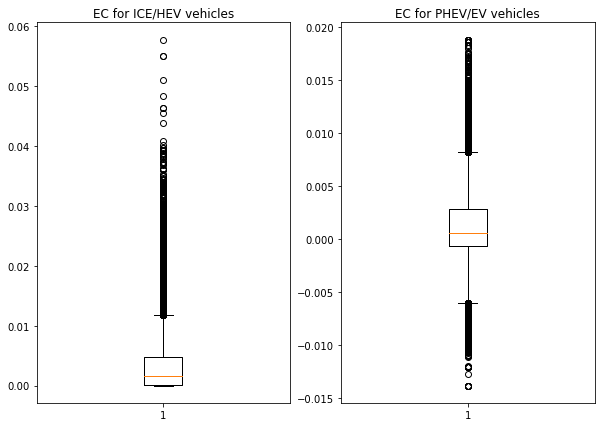

Average EC ICE: 0.0032574152263156668
Average EC EV: 0.0011408219467592066


In [8]:
list_values = []
df_EC171101 = pd.read_csv (path_out+'VED_171101_week.csv')
list_values.append(boxplot_EC_perVehicleType(df_EC171101))

In [9]:
for file in os.listdir(path_out):
    if file.endswith("_week.csv"):
        df_EC171115 = pd.read_csv (path_out+file)
        list_values.append(boxplot_EC_perVehicleType(df_EC171115, True))

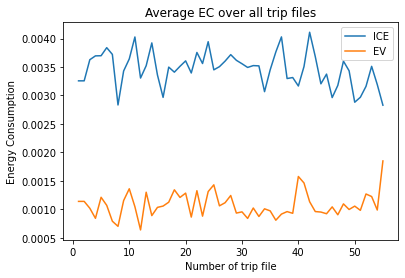

In [10]:
import matplotlib.pyplot as plt
# line 1 points
x1 = list(range(1, len(list_values)+1))
y1 = [row[0] for row in list_values]
# plotting the line 1 points 
plt.plot(x1, y1, label = "ICE")
# line 2 points
x2 = list(range(1, len(list_values)+1))
y2 = [row[1] for row in list_values]
# plotting the line 2 points 
plt.plot(x2, y2, label = "EV")
plt.xlabel('Number of trip file')
# Set the y axis label of the current axis.
plt.ylabel('Energy Consumption')
# Set a title of the current axes.
plt.title('Average EC over all trip files')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()